<a href="https://colab.research.google.com/github/muksmuks/computer_vision/blob/master/project_11/Week_11_W6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers
import keras.models
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator



Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('../content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at ../content/drive/


**Demonstration of below learnings**

Use the base code provided and perform the below learnings
1. CutOut as image augmentation strategy
2. Use LR Finder to find the best starting learning rate
3. Use SDG with Momentum



**Other Instructions**
1. Train for 100 Epochs. 
2. Keep Verbose = 0 (no logs)
3. Print the top accuracy
4. Show Training and Test Accuracy curves

In [3]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 6s 0us/step


In [4]:
print (num_classes)
print (num_train)
print (train_features.shape)

10
50000
(50000, 32, 32, 3)


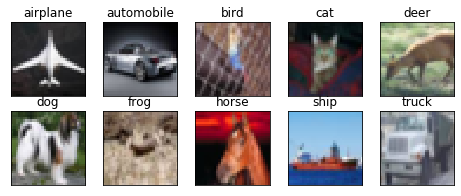

In [5]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

##Model Definition

In [0]:
def custom_model():
  # Define the model
  model = Sequential()
  model.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))
  
  model.add(Convolution2D(32, 1, 1))


  model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.3))

  model.add(Convolution2D(32, 1, 1))


  model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Convolution2D(10, 1, 1))

  model.add(AveragePooling2D(pool_size = (4,4)))
  model.add(Flatten())
  model.add(Activation('softmax'))
  return model



#Cutout Parameters


###Parameters are fully configurable as:

**get_random_eraser**(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3,
                                   v_l=0, v_h=255, pixel_level=False)

p : the probability that random erasing is performed

s_l, s_h : minimum / maximum proportion of erased area against input image

r_1, r_2 : minimum / maximum aspect ratio of erased area

v_l, v_h : minimum / maximum value for erased area

pixel_level : pixel-level randomization for erased area

###Creating a new ImageGenerator with 
1 Cutout Added (v_l=0,v_h=255, s_l=0.02, s_h=0.2)

2 feature_wise_centering

3 feature_wise_standarization

##Define the get_random_eraser function as provided by 
#####https://github.com/yu4u/cutout-random-erasing/blob/master/random_eraser.py

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.2, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [0]:
from keras.datasets import cifar10
# load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

datagen = ImageDataGenerator(featurewise_center=True,
                            featurewise_std_normalization=True,
                            preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True))


datagen.fit(x_train)



###Define LR finder


In [0]:
bs = 64

from keras.callbacks import Callback

class LR_Finder(Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])

In [0]:
lr_finder = LR_Finder(start_lr=1e-5, end_lr=10, step_size=np.ceil(x_train.shape[0]/bs))

In [13]:
model = custom_model()
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  after removing the cwd from sys.path.








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Upd

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (1, 1))`


##Finding the best learning rate

In [14]:
# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(x_train, Y_train, batch_size = 128),
                                 samples_per_epoch = x_train.shape[0], nb_epoch = 100, 
                                 validation_data = (x_test, Y_test), verbose=1, callbacks=[lr_finder])

end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<__main__..., steps_per_epoch=390, epochs=100)`
  """




Epoch 1/100
390/390 [==============================] - 30s 77ms/step - loss: 2.7601 - acc: 0.1726 - val_loss: 13.8140 - val_acc: 0.1335
Epoch 2/100
375/390 [===========================>..] - ETA: 0s - loss: 3.1464 - acc: 0.2908Model took 54.42 seconds to train


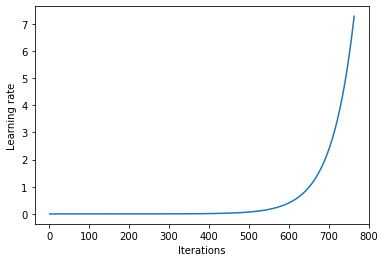

In [15]:
lr_finder.plot_lr()

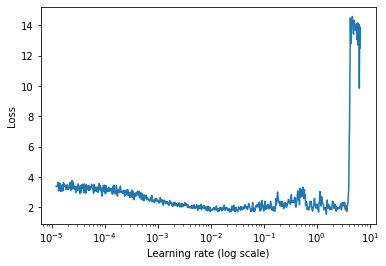

In [16]:
lr_finder.plot()

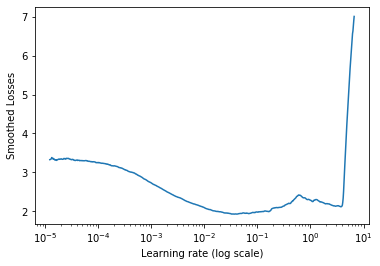

In [17]:
lr_finder.plot_smoothed_loss()

##The loss function decreases fast when the learning rate is between 0.0001 and 0.01. Hence taking 0.01 as the learning rate and training the model for 100 epochs

In [0]:
selected_lr = 0.01

In [0]:
from keras import optimizers
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras import optimizers

checkpointer = ModelCheckpoint(filepath='../content/drive/My Drive/Learnings/Machine Learning/Deep Learning/EVA/Week_11/model_session11.h5', monitor='val_acc', mode='auto', verbose = 1, save_best_only=True)
lr_reducer = ReduceLROnPlateau(monitor='val_acc',factor=0.8, cooldown=0, patience=5, min_lr=0.5e-9,verbose = 1)

# Compile the model
sgd = optimizers.SGD(lr=selected_lr, decay=0, momentum=0.9, nesterov=False)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)       

In [21]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,
                             preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True))


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(x_train, Y_train, batch_size = 64),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (x_test, Y_test), callbacks=[checkpointer,lr_reducer],verbose=0)
end = time.time()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=0, steps_per_epoch=781, epochs=100)`
  del sys.path[0]



Epoch 00001: val_acc improved from -inf to 0.28720, saving model to ../content/drive/My Drive/Learnings/Machine Learning/Deep Learning/EVA/Week_11/model_session11.h5

Epoch 00002: val_acc improved from 0.28720 to 0.35390, saving model to ../content/drive/My Drive/Learnings/Machine Learning/Deep Learning/EVA/Week_11/model_session11.h5

Epoch 00003: val_acc improved from 0.35390 to 0.41440, saving model to ../content/drive/My Drive/Learnings/Machine Learning/Deep Learning/EVA/Week_11/model_session11.h5

Epoch 00004: val_acc improved from 0.41440 to 0.43790, saving model to ../content/drive/My Drive/Learnings/Machine Learning/Deep Learning/EVA/Week_11/model_session11.h5

Epoch 00005: val_acc improved from 0.43790 to 0.45370, saving model to ../content/drive/My Drive/Learnings/Machine Learning/Deep Learning/EVA/Week_11/model_session11.h5

Epoch 00006: val_acc improved from 0.45370 to 0.48300, saving model to ../content/drive/My Drive/Learnings/Machine Learning/Deep Learning/EVA/Week_11/mo

Model took 3193.81 seconds to train


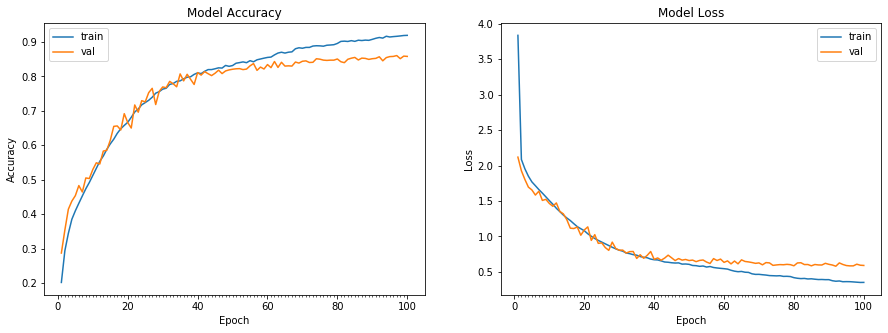

Accuracy on test data is: 85.78


In [22]:
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(x_test, Y_test, model))

In [0]:
model= keras.models.load_model('../content/drive/My Drive/Learnings/Machine Learning/Deep Learning/EVA/Week_11/model_session11.h5')


#####Top Accuracy : 0.8602

In [25]:
score = model.evaluate(x_test, Y_test, batch_size=64)
print (score[1])

10000/10000 [==============================] - 2s 237us/step
0.8602


####Find Misclassified Images

In [0]:
Y_pred = model.predict(x_test)

import pandas as pd
ytest = []
ypred = []

for i in range(len(Y_test)):
  ytest.append(np.argmax(Y_test[i]))
  ypred.append(np.argmax(Y_pred[i]))

df = pd.DataFrame()
df['Actual'] = ytest
df['Predicted']  =  ypred
misclassified = df.index[df['Actual']!=df['Predicted']].tolist()

####Misclassified Image - Randomly selected - 25

In [0]:
import random
misclassified25 = random.sample(misclassified, 25)

####GradCAM results on 25 misclassified images

Image index is 1884
actual class horse
predicted class dog


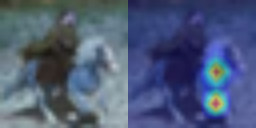

 
Image index is 1100
actual class horse
predicted class deer


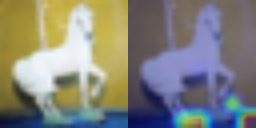

 
Image index is 2651
actual class dog
predicted class bird


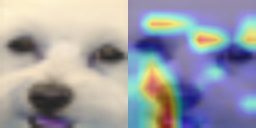

 
Image index is 2719
actual class deer
predicted class cat


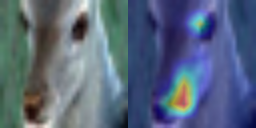

 
Image index is 2486
actual class horse
predicted class deer


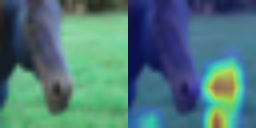

 
Image index is 7906
actual class bird
predicted class deer


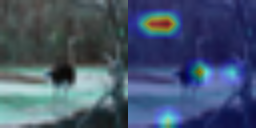

 
Image index is 1056
actual class cat
predicted class dog


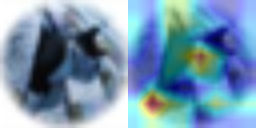

 
Image index is 1985
actual class frog
predicted class bird


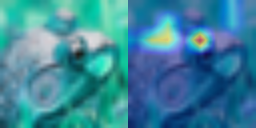

 
Image index is 8641
actual class horse
predicted class deer


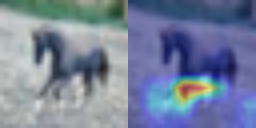

 
Image index is 9989
actual class bird
predicted class deer


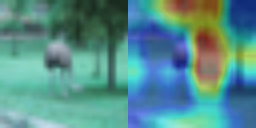

 
Image index is 9910
actual class deer
predicted class horse


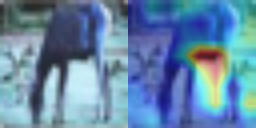

 
Image index is 2630
actual class bird
predicted class frog


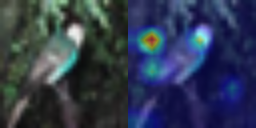

 
Image index is 4748
actual class airplane
predicted class automobile


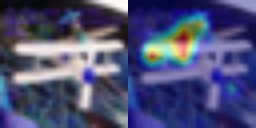

 
Image index is 2320
actual class dog
predicted class bird


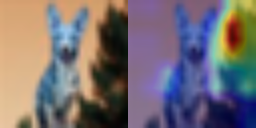

 
Image index is 1823
actual class airplane
predicted class horse


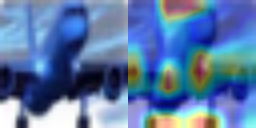

 
Image index is 7509
actual class cat
predicted class automobile


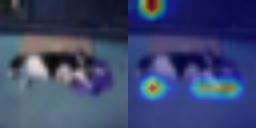

 
Image index is 5070
actual class horse
predicted class dog


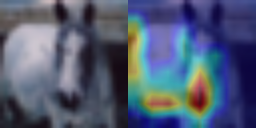

 
Image index is 6985
actual class airplane
predicted class ship


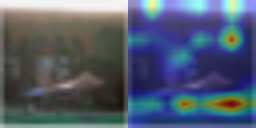

 
Image index is 2292
actual class dog
predicted class cat


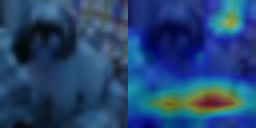

 
Image index is 912
actual class airplane
predicted class bird


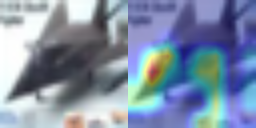

 
Image index is 6580
actual class automobile
predicted class airplane


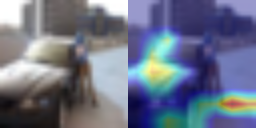

 
Image index is 2299
actual class frog
predicted class cat


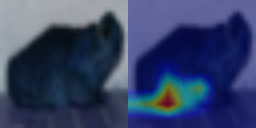

 
Image index is 6497
actual class deer
predicted class bird


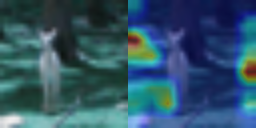

 
Image index is 8877
actual class truck
predicted class automobile


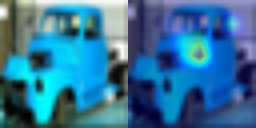

 
Image index is 678
actual class airplane
predicted class automobile


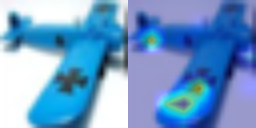

In [30]:
import cv2
from google.colab.patches import cv2_imshow

images = misclassified25

for j in images:
  x = x_test[j]
  x = np.expand_dims(x, axis=0)
  preds = model.predict(x,batch_size=1)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("conv2d_8")

  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(256):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap) 
  img = (x_test[j])
  img = cv2.resize(img,(128,128))
  heatmap = cv2.resize(heatmap, (128, 128))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  concatimg = cv2.hconcat([img,superimposed_img])
  # Display the concatenated image
  print ("Image index is " + str(j))
  print ("actual class " + str(class_names[df['Actual'][j]]))
  print ("predicted class " + str(class_names[df['Predicted'][j]]))
  cv2_imshow(concatimg)
  cv2.waitKey(0)
  print (" ")
  j = j + 1